# Inspect data about Heatwaves in Lake Como
### 2023/08/07

In [ ]:
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4 as nc
import datetime as dt
import matplotlib.pyplot as plt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
## Extract data with xarray
### Not working: dictionary update sequence element #0 has length 1; 2 is required
# lc_hw = xr.Dataset("./data/ERA5_and_derivates/TmaxTS_19502022_clim19812010_summer_ERA5_fixedclim.nc")

In [55]:
plot_dir="./plots_for_reports/"

In [6]:
## Extract data with netcdf4 
lc_hw = nc.Dataset("./data/ERA5_and_derivates/TmaxTS_19502022_clim19812010_summer_ERA5_fixedclim.nc")

In [7]:
## What are the variables?
### It appears that dimensions, years and days, are not variable, hence
### it's not possible to extract them

vars = list(lc_hw.variables.keys())
daily_vars = ['Monte_Tmax', 'Valle_Tmax', 'Monte_HWintensity', 'Valle_HWintensity', 'Monte_HWocc', 'Valle_HWocc']
calday_vars = ['Monte_pc90', 'Valle_pc90']


In [8]:
## Determining the years
### Length of fields along the years-axis is 73, hence from 1950 to 2022


years = np.array(range(1950,2023))


In [9]:
## Determining the days
### Length of fields along the days-axis is 123, 4 months from May to August
### These days can be represented with m*100+d, where m is month and d is day
### or counting integers from the beginning of the year (ignoring leap years)

d5 = np.array(range(501,532))
d6 = np.array(range(601,631))
d7 = np.array(range(701,732))
d8 = np.array(range(801,832))

days_name= np.concatenate((d5,d6,d7,d8))
days = np.array(range(31+28+31+30+1,31+28+31+30+31+30+31+31+1))


In [29]:
## Initialize a dataframe to store the daa
### Row indices will be the number of days since 1950-01-01
### (y-1950)*365+d, add 1 unit on leap years
### and columns will be the variables

### Determine the indices and daynames

indices = np.empty([1,0])
names = np.empty([1,0])

In [30]:
def create_indices_4_df(y,days):
    """
    Creates an array of integers that represent number of days from 1950/01/01
    
    Parameters
    ----------
    y : int
        year
    m : int
        month
        
    Returns
    --------
    indices1 : numpy array of int
        number of days from 1950/01/01
    
    """
    indices1 = (y-1950)*365 + days
    if y%4 == 0:
        indices1 = indices1+1
    return(indices1)
        
 

In [31]:
### Create array of indices and names related to the daily data

list_indices = [create_indices_4_df(y,days) for y in years]
indices = np.concatenate(list_indices)

list_names = [y*10000+days_name for y in years]
names = np.concatenate(list_names)


In [32]:
## Create dataframe for daily data

lchw_daily = pd.DataFrame(list((names)), index = indices)
lchw_daily.columns = ['date_int']
lchw_daily['date'] = lchw_daily.apply(lambda x: dt.datetime.strptime(str(x['date_int']), '%Y%m%d'), axis=1)
lchw_daily['year'] = lchw_daily.apply(lambda x: int(x['date'].year), axis=1)
lchw_daily['month'] = lchw_daily.apply(lambda x: int(x['date'].month), axis=1)
lchw_daily['day'] = lchw_daily.apply(lambda x: int(x['date'].day), axis=1)
lchw_daily = lchw_daily.drop(labels=('date_int'),axis=1)

In [33]:
## Create dataframe for calendar-day data, i.e. seasonal cycle of p90

lchw_calday = pd.DataFrame(list(days), index = days)
lchw_calday.columns = ['calendar_day']
lchw_calday['calday_int'] = days_name
lchw_calday['month'] = days_name//100
lchw_calday['day'] = days_name%100
lchw_calday = lchw_calday.drop(labels='calday_int', axis=1)

In [34]:
## Extract daily series from the netcdf and store them in the dataframe

list_daily_series = [np.concatenate(np.array(lc_hw[var])) for var in daily_vars]
df_daily_series = pd.DataFrame(list_daily_series).transpose()
df_daily_series.columns = daily_vars
df_daily_series.index = indices

lchw_daily = pd.concat([lchw_daily, df_daily_series], axis=1)

In [35]:
## Convert from Kelvin to Celsius
for v in [ 'Monte_Tmax', 'Valle_Tmax']:
    lchw_daily[v] = lchw_daily[v]-273.15
 
 ## Convert in np.nan all the large values

for v in ['Monte_HWintensity', 'Valle_HWintensity', 'Monte_HWocc', 'Valle_HWocc']:
    lchw_daily.loc[lchw_daily[v]>100000,[v]] = np.nan
    

In [36]:
lchw_daily.columns

Index(['date', 'year', 'month', 'day', 'Monte_Tmax', 'Valle_Tmax',
       'Monte_HWintensity', 'Valle_HWintensity', 'Monte_HWocc', 'Valle_HWocc'],
      dtype='object')

In [37]:
## Extract climatological data from the netcdf and store them in the dataframe

list_calday_series = [np.array(lc_hw[var]) for var in calday_vars]
df_calday_series = pd.DataFrame(list_calday_series).transpose()
df_calday_series.columns = calday_vars
df_calday_series.index = days

lchw_calday= pd.concat([lchw_calday, df_calday_series], axis=1)

In [38]:
for v in [ 'Monte_pc90', 'Valle_pc90']:
    lchw_calday[v] = lchw_calday[v]-273.15

In [39]:
lchw_daily.set_index('date',inplace=True)

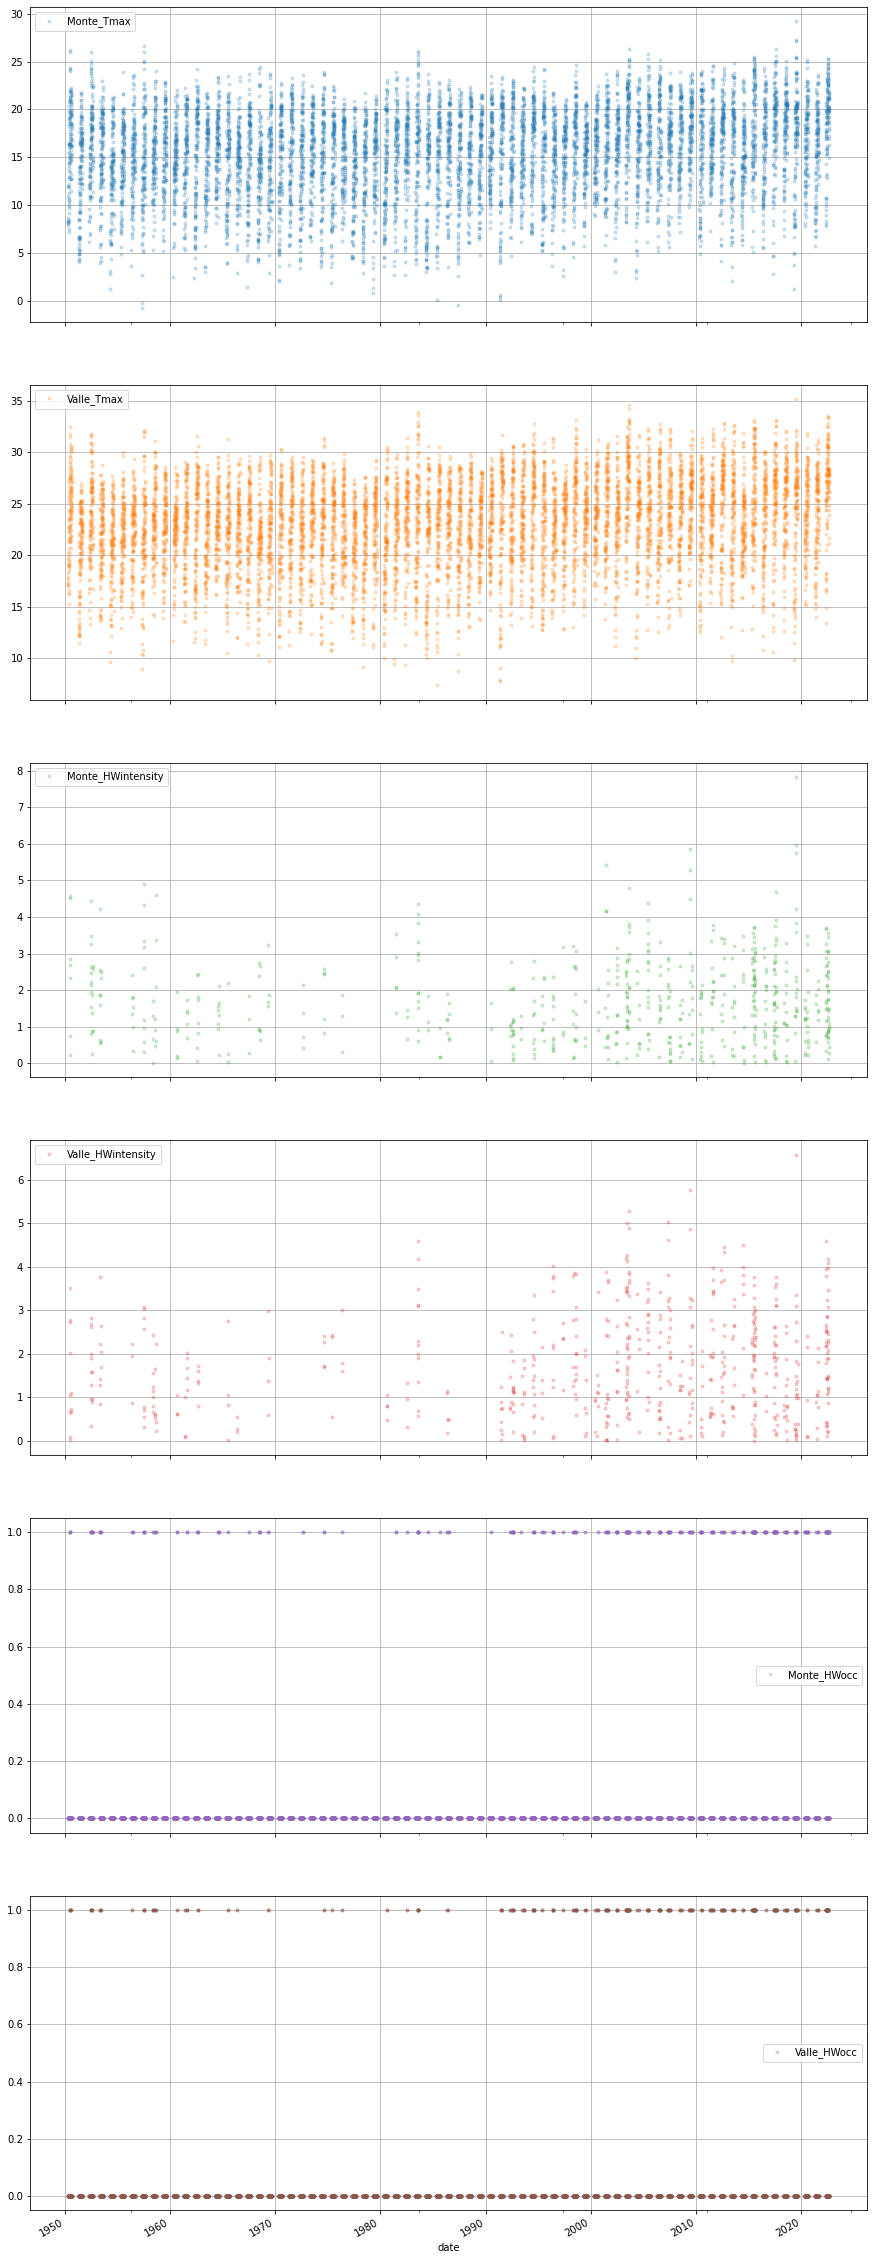

In [42]:
plt.rcParams['figure.figsize'] = [15, 45]
lchw_daily[['Monte_Tmax', 'Valle_Tmax',
            'Monte_HWintensity', 'Valle_HWintensity', 
            'Monte_HWocc', 'Valle_HWocc']].plot(subplots=True, grid=True,
            layout=(6,1),marker='.',linestyle='none',alpha=0.2)
plt.show()

In [43]:
lchw = lchw_daily.reset_index().merge(lchw_calday,how='left',on=['month','day'])
lchw = lchw.set_index('date')

In [46]:
lchw.columns

Index(['year', 'month', 'day', 'Monte_Tmax', 'Valle_Tmax', 'Monte_HWintensity',
       'Valle_HWintensity', 'Monte_HWocc', 'Valle_HWocc', 'calendar_day',
       'Monte_pc90', 'Valle_pc90'],
      dtype='object')

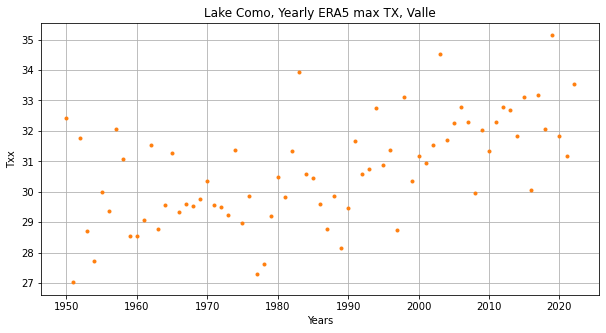

In [56]:
where = 'Valle'
a = lchw.groupby('year')[f'{where}_Tmax'].max()
a.columns = ['Txx']
plt.rcParams['figure.figsize'] = [10, 5]
plt.plot(a,c='tab:orange',marker='.',linestyle='none')

plt.title(f'Lake Como, Yearly ERA5 max TX, {where}')
plt.xlabel('Years', fontsize=10)
plt.ylabel(f'Txx', fontsize=10)
plt.grid(True)

plt.savefig(f"{plot_dir}CLINT010_LakeComo_{where}_yearly_TXx.png", facecolor='w')

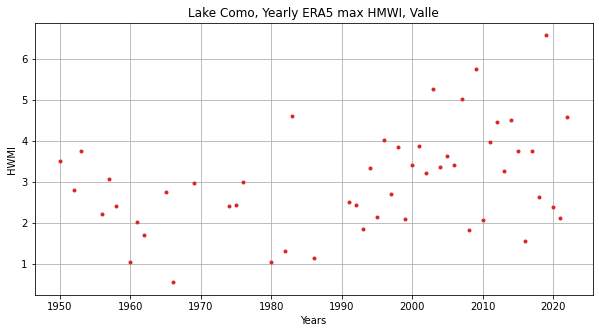

In [57]:
where = 'Valle'
a = lchw.groupby('year')[f'{where}_HWintensity'].max()
a.columns = ['maxHWI']
plt.rcParams['figure.figsize'] = [10, 5]
plt.plot(a,c='tab:red',marker='.',linestyle='none')

plt.title(f'Lake Como, Yearly ERA5 max HMWI, {where}')
plt.xlabel('Years', fontsize=10)
plt.ylabel(f'HWMI', fontsize=10)

plt.grid(True)

plt.savefig(f"{plot_dir}CLINT012_LakeComo_{where}_yearly_HMWI.png", facecolor='w')

In [89]:
y = 2019
where = 'Valle'

In [ ]:
plt.rcParams['figure.figsize'] = [10,5]
fig, ax = plt.subplots()
plt.plot(lchw[lchw.year==y][f'{where}_Tmax'], marker='.',
         linestyle='none',c='tab:orange', label = f'Daily Tmax {y}')
plt.plot(lchw[lchw.year==y][f'{where}_pc90'],c='black', label = '90p of tmax (31d window, 1981-2010)')

plt.title(f'Lake Como, Daily ERA5 tmax {y}, {where}')
plt.xlabel('Days of {y}', fontsize=10)
plt.ylabel(f'Temperature [C]', fontsize=10)
plt.grid(True)
plt.ylim([8,36])
ax.legend(loc='lower right')

plt.savefig(f"{plot_dir}CLINT016_LakeComo_{where}_{y}_dailytmax.png", facecolor='w')

NameError: name 'plt' is not defined

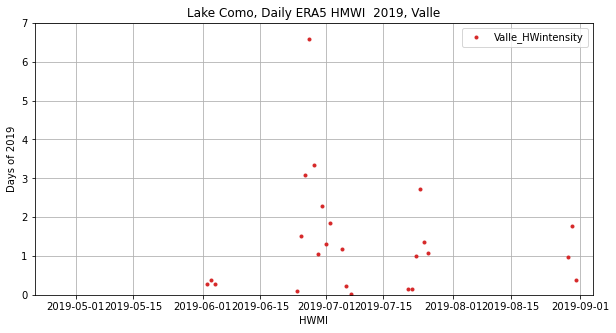

In [91]:

clmn = f'{where}_HWintensity'

plt.rcParams['figure.figsize'] = [10, 5]
plt.plot(lchw[lchw.year==y][clmn], marker='.',
         linestyle='none',c='tab:red', label = clmn)
#plt.plot(lchw[lchw.year==y]['Valle_pc90'],c='black')
plt.xlim([dt.datetime(y,4,21), dt.datetime(y,9,4)])
plt.legend()
plt.title(f'Lake Como, Daily ERA5 HMWI  {y}, {where}')
plt.xlabel('HWMI', fontsize=10)
plt.ylabel(f'Days of {y}', fontsize=10)
plt.ylim([0,7])
plt.grid(True)

plt.savefig(f"{plot_dir}CLINT017_LakeComo_{where}_{y}_dailyHMWI.png", facecolor='w')

In [92]:
y = 2022
where = 'Valle'

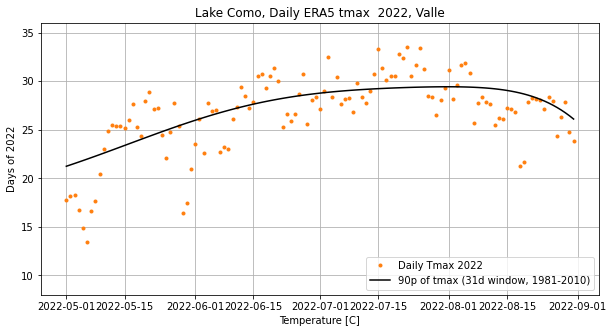

In [93]:
plt.rcParams['figure.figsize'] = [10,5]
fig, ax = plt.subplots()

plt.plot(lchw[lchw.year==y][f'{where}_Tmax'], marker='.',
         linestyle='none',c='tab:orange', label = f'Daily Tmax {y}')
plt.plot(lchw[lchw.year==y][f'{where}_pc90'],c='black', label = '90p of tmax (31d window, 1981-2010)')

plt.title(f'Lake Como, Daily ERA5 tmax  {y}, {where}')
plt.xlabel('Temperature [C]', fontsize=10)
plt.ylabel(f'Days of {y}', fontsize=10)
plt.grid(True)
ax.legend(loc='lower right')
plt.ylim([8,36])
plt.savefig(f"{plot_dir}CLINT022_LakeComo_{where}_{y}_dailytmax.png", facecolor='w')

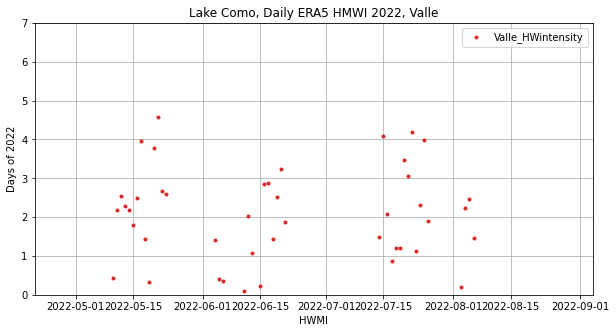

In [94]:

clmn = f'{where}_HWintensity'

plt.rcParams['figure.figsize'] = [10, 5]
plt.plot(lchw[lchw.year==y][clmn], marker='.',
         linestyle='none',c='tab:red', label = clmn)
#plt.plot(lchw[lchw.year==y]['Valle_pc90'],c='black')
plt.xlim([dt.datetime(y,4,21), dt.datetime(y,9,4)])
plt.legend()
plt.title(f'Lake Como, Daily ERA5 HMWI {y}, {where}')
plt.xlabel('HWMI', fontsize=10)
plt.ylabel(f'Days of {y}', fontsize=10)
plt.ylim([0,7])
plt.grid(True)

plt.savefig(f"{plot_dir}CLINT023_LakeComo_{where}_{y}_dailyHMWI.png", facecolor='w')

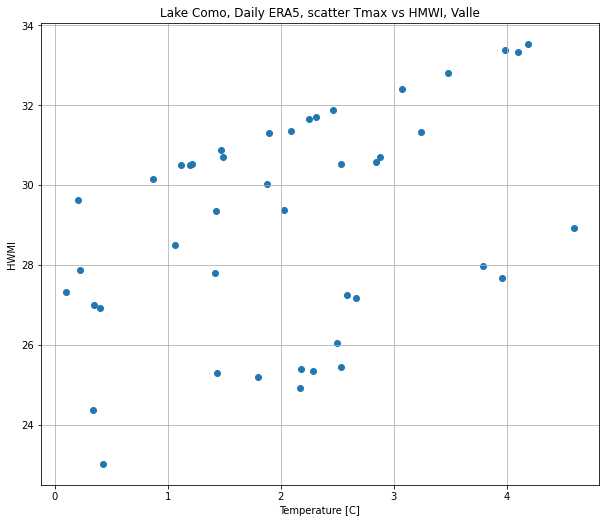

In [95]:
plt.rcParams['figure.figsize'] = [10, 8.5]
plt.scatter(lchw_daily[lchw_daily.year==y]['Valle_HWintensity'],
            lchw_daily[lchw_daily.year==y]['Valle_Tmax']            
        )
plt.title(f'Lake Como, Daily ERA5, scatter Tmax vs HMWI, {where}')
plt.xlabel('Temperature [C]', fontsize=10)
plt.ylabel(f'HWMI', fontsize=10)

plt.grid(True)

/var/folders/_8/tp74128j6zz51s53xxlr9vx80000gv/T/ipykernel_23295/573379802.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  lchw[lchw.year==y][~pd.isnull(lchw.Valle_HWintensity)]


,year,month,day,Monte_Tmax,Valle_Tmax,Monte_HWintensity,Valle_HWintensity,Monte_HWocc,Valle_HWocc,calendar_day,Monte_pc90,Valle_pc90
date,,,,,,,,,,,,
2022-05-10,2022,5,10,15.902222,23.017731,0.731677,0.424515,1.0,1.0,130,15.170532,22.593201
2022-05-11,2022,5,11,17.760681,24.921936,2.417168,2.172112,1.0,1.0,131,15.343506,22.749817
2022-05-12,2022,5,12,19.186188,25.442566,3.671558,2.535328,1.0,1.0,132,15.514648,22.907227
2022-05-13,2022,5,13,18.572021,25.348938,2.887959,2.283603,1.0,1.0,133,15.684082,23.065338
2022-05-14,2022,5,14,17.560486,25.399719,1.708477,2.175761,1.0,1.0,134,15.851990,23.223938
2022-05-15,2022,5,15,17.656708,25.180420,1.638186,1.797495,1.0,1.0,135,16.018524,23.382904
2022-05-16,2022,5,16,16.944366,26.042755,0.760586,2.500673,1.0,1.0,136,16.183807,23.542084
2022-05-17,2022,5,17,19.596008,27.661041,3.248147,3.959794,1.0,1.0,137,16.347870,23.701263
2022-05-18,2022,5,18,18.000061,25.299133,1.489286,1.438837,1.0,1.0,138,16.510773,23.860291


In [77]:
lchw.to_csv('LakeComo_tmax_HW.csv',na_rep='NaN')